<a href="https://colab.research.google.com/github/bhoomibhoomi7795-code/image-classification-with-cnn/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies (uncomment for Colab)
# !pip install tensorflow matplotlib imageio tqdm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Simple Generator Network
def build_simple_generator(latent_dim):
    """Generator: Maps random noise to image space."""
    model = keras.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(1024),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),

        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ], name='generator')
    return model

# Simple Discriminator Network
def build_simple_discriminator(img_shape):
    """Discriminator: Classifies images as real or fake."""
    model = keras.Sequential([
        layers.Flatten(input_shape=img_shape),

        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    return model

# Test the architectures
latent_dim = 100
img_shape = (28, 28, 1)

gen = build_simple_generator(latent_dim)
disc = build_simple_discriminator(img_shape)

print("Generator Summary:")
gen.summary()
print("\nDiscriminator Summary:")
disc.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# DCGAN Generator
def build_dcgan_generator(latent_dim=100):
    model = keras.Sequential(name='dcgan_generator')

    # Foundation for 7x7 image
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 7x7x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 14x14x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# DCGAN Discriminator
def build_dcgan_discriminator():
    model = keras.Sequential(name='dcgan_discriminator')

    # 28x28x1 -> 14x14x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 14x14x64 -> 7x7x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and classify
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Build models
generator = build_dcgan_generator()
discriminator = build_dcgan_discriminator()

print("DCGAN Generator:")
generator.summary()
print("\nDCGAN Discriminator:")
discriminator.summary()

DCGAN Generator:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "dcgan_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)


DCGAN Discriminator:


Model: "dcgan_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

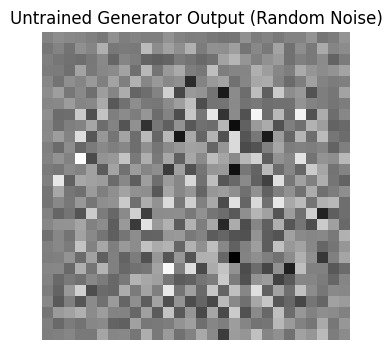

Discriminator output: 0.0014
(Before training, this is random)


In [ ]:
# Test the untrained generator
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(4, 4))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Untrained Generator Output (Random Noise)')
plt.axis('off')
plt.show()

# Test discriminator
decision = discriminator(generated_image)
print(f"Discriminator output: {decision.numpy()[0][0]:.4f}")
print("(Before training, this is random)")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset shape: (60000, 28, 28)
Number of training images: 60,000


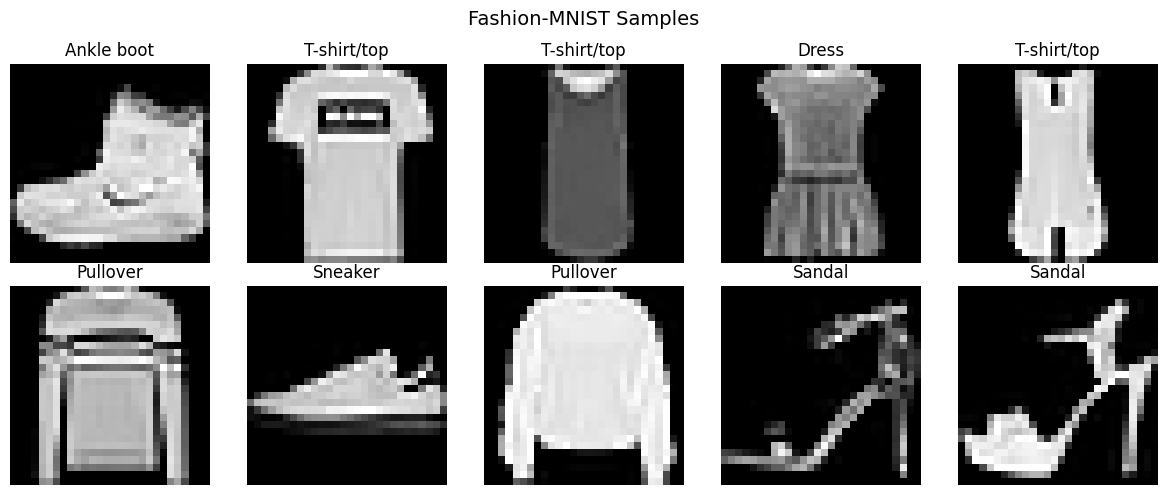

In [ ]:
# Load Fashion-MNIST dataset
(train_images, train_labels), (_, _) = keras.datasets.fashion_mnist.load_data()

# Fashion-MNIST class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Dataset shape: {train_images.shape}")
print(f"Number of training images: {len(train_images):,}")

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]])
    ax.axis('off')
plt.suptitle('Fashion-MNIST Samples', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Preprocess the data

# Normalize to [-1, 1] (for tanh activation)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

print(f"Min value: {train_images.min()}, Max value: {train_images.max()}")

# Create tf.data.Dataset for efficient batching
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Number of batches: {len(train_dataset)}")

Min value: -1.0, Max value: 1.0
Number of batches: 235


In [ ]:
# Define loss function and optimizers

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """Discriminator wants to correctly classify real and fake."""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real = 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake = 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Generator wants discriminator to think fakes are real."""
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Wants D(G(z)) = 1

# Optimizers with recommended learning rates
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

print("✅ Loss functions and optimizers defined!")

✅ Loss functions and optimizers defined!


In [ ]:
# Training configuration
LATENT_DIM = 100
EPOCHS = 50  # Increase for better results
num_examples_to_generate = 16

# Seed for consistent visualization
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

@tf.function
def train_step(images):
    """Single training step for both G and D."""
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute and apply gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

Initial random output:


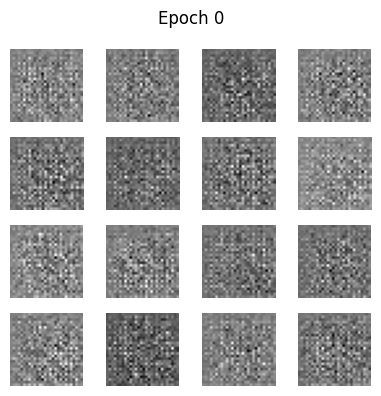

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    """Generate and display images during training."""
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=12)
    plt.tight_layout()
    plt.show()

# Test visualization function
print("Initial random output:")
generate_and_save_images(generator, 0, seed)

In [ ]:
# Training loop
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        # Track average losses
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        # Display progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            print(f'Epoch {epoch+1}/{epochs}')
            print(f'  Generator Loss: {gen_losses[-1]:.4f}')
            print(f'  Discriminator Loss: {disc_losses[-1]:.4f}')
            print(f'  Time: {time.time()-start:.2f}s')

    # Final generation
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return gen_losses, disc_losses

print("🚀 Starting training...")
print(f"Training for {EPOCHS} epochs with batch size {BATCH_SIZE}")
print("This may take 10-20 minutes depending on your hardware.\n")

🚀 Starting training...
Training for 50 epochs with batch size 256
This may take 10-20 minutes depending on your hardware.



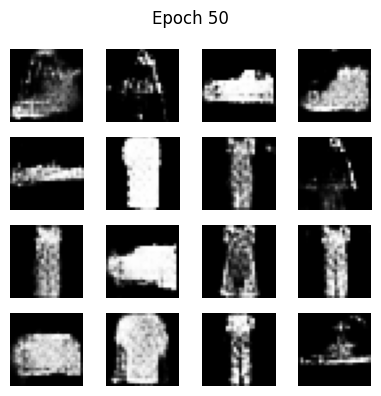

In [ ]:
# Run training!
gen_losses, disc_losses = train(train_dataset, EPOCHS)

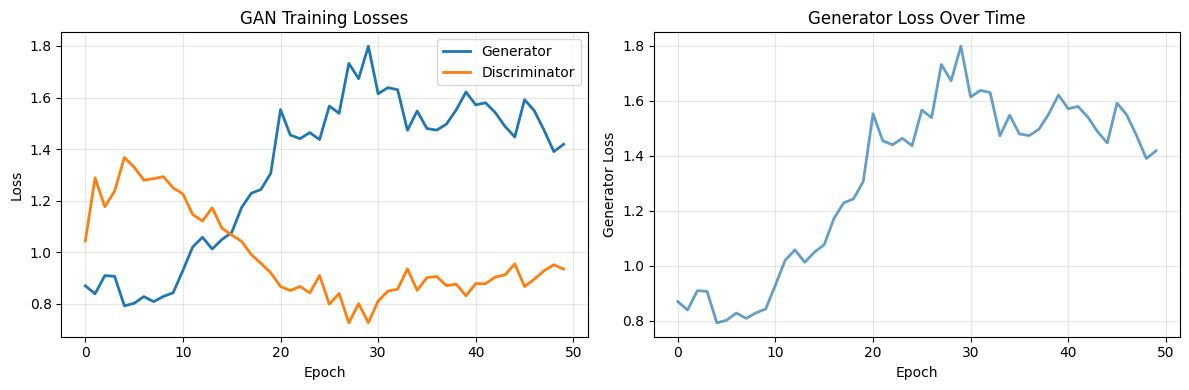

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gen_losses, label='Generator', linewidth=2)
plt.plot(disc_losses, label='Discriminator', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gen_losses, label='Generator', linewidth=2, alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1527628462.py:15: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


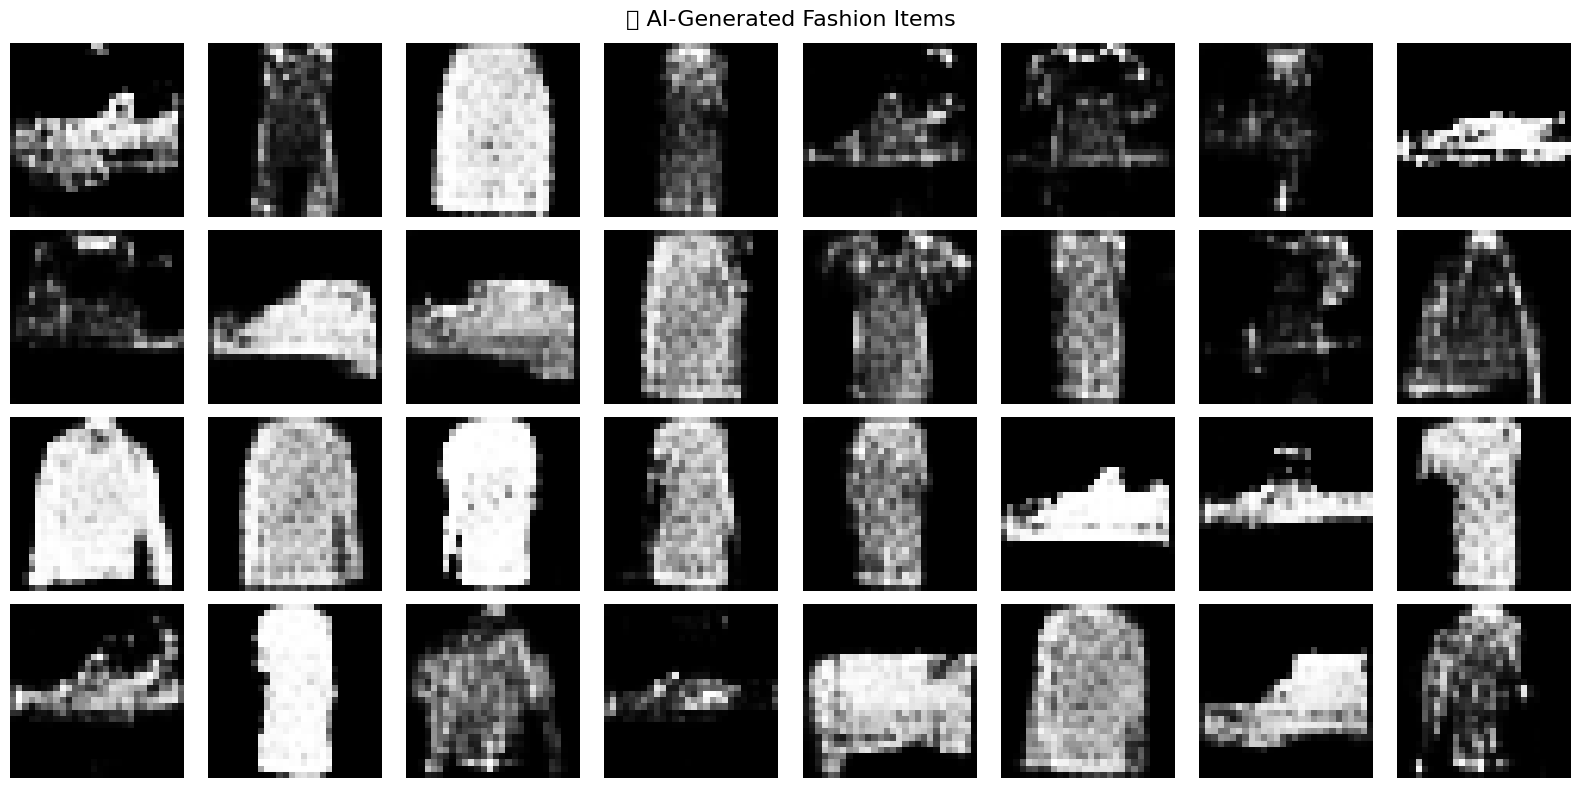

In [ ]:
# Generate a grid of fashion items
def generate_fashion_grid(generator, n_rows=4, n_cols=8):
    """Generate a grid of fashion items."""
    n_samples = n_rows * n_cols
    noise = tf.random.normal([n_samples, LATENT_DIM])
    generated = generator(noise, training=False)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        img = generated[i, :, :, 0] * 127.5 + 127.5
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.suptitle('🎨 AI-Generated Fashion Items', fontsize=16)
    plt.tight_layout()
    plt.show()

generate_fashion_grid(generator)

Watch one fashion item morph into another!


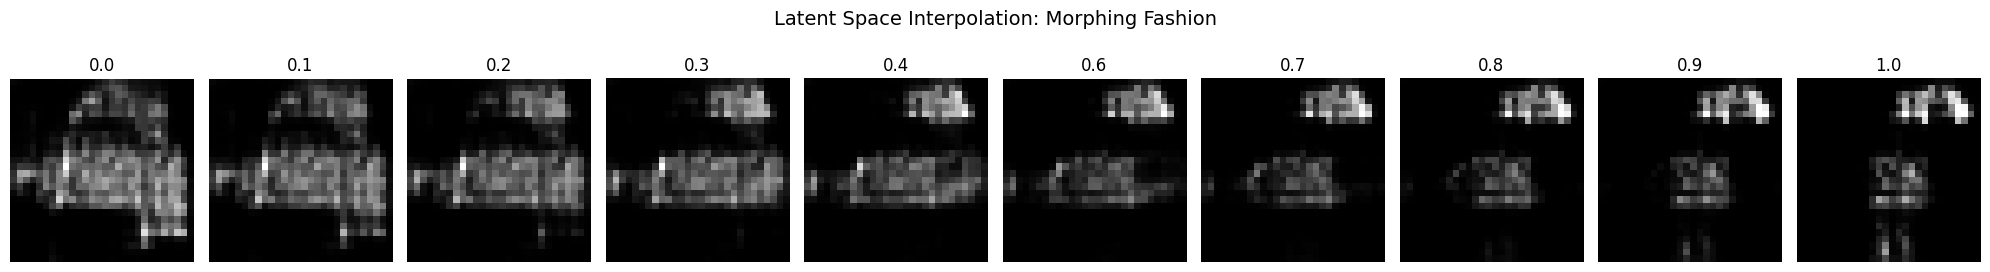

In [ ]:
# Latent Space Interpolation - Watch fashion morph!
def interpolate_latent_space(generator, n_steps=10):
    """Interpolate between two random points in latent space."""
    # Two random latent vectors
    z1 = tf.random.normal([1, LATENT_DIM])
    z2 = tf.random.normal([1, LATENT_DIM])

    # Linear interpolation
    ratios = np.linspace(0, 1, n_steps)

    fig, axes = plt.subplots(1, n_steps, figsize=(20, 3))

    for i, ratio in enumerate(ratios):
        z = z1 * (1 - ratio) + z2 * ratio
        img = generator(z, training=False)
        axes[i].imshow(img[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'{ratio:.1f}')

    plt.suptitle('Latent Space Interpolation: Morphing Fashion', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Watch one fashion item morph into another!")
interpolate_latent_space(generator)

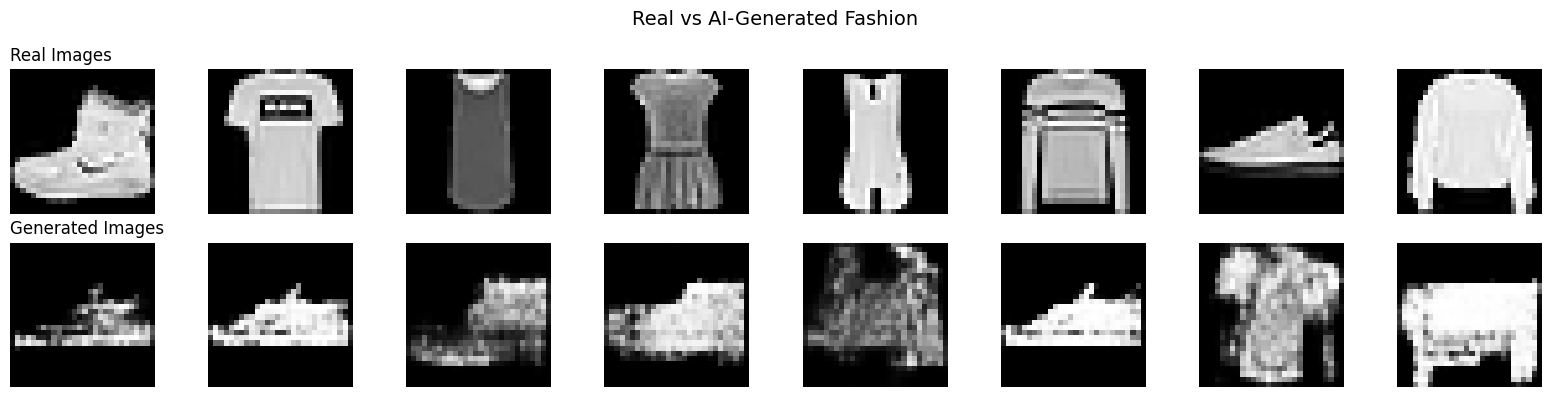

In [ ]:
# Compare real and generated images side by side
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

# Real images (top row)
for i in range(8):
    axes[0, i].imshow(train_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Real Images', fontsize=12, loc='left')

# Generated images (bottom row)
noise = tf.random.normal([8, LATENT_DIM])
generated = generator(noise, training=False)
for i in range(8):
    axes[1, i].imshow(generated[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Generated Images', fontsize=12, loc='left')

plt.suptitle('Real vs AI-Generated Fashion', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Demonstration: Label Smoothing for stable training
def discriminator_loss_with_smoothing(real_output, fake_output, smoothing=0.1):
    """Use label smoothing: real=0.9 instead of 1.0"""
    real_labels = tf.ones_like(real_output) * (1 - smoothing)  # 0.9 instead of 1
    fake_labels = tf.zeros_like(fake_output)

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    return real_loss + fake_loss

print("💡 Label smoothing prevents discriminator from becoming overconfident!")

💡 Label smoothing prevents discriminator from becoming overconfident!
